Привет, меня зовут Артем Хуршудов. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>

#### <font color='orange'>Полезные ссылки:</font>
* Полезная лекция про временные ряды: https://www.youtube.com/watch?v=u433nrxdf5k .

### <font color='orange'>Общее впечатление</font>
* Большое спасибо за проделанную работу. Видно, что приложено много усилий.
* Отлично, что ноутбук хорошо структурирован. Приятно проверять такие работы.
* Тебе удалось добиться очень хорошего качества, поздравляю!
* Проект может быть зачтен, но я его отправлю назад, чтобы у тебя была возможность задать вопросы, при желании. Однако, ты можешь просто вернуть проект в таком же виде и я его зачту.

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Спасибо за ревью! Возвращаю работу на зачет.
</div>

### <font color='orange'>Общее впечатление (ревью 2)</font>
* Проект зачтен!
* Удачи в дальнейшем обучении и следующих работах!

#Прогнозирование заказов такси


## Описание проекта
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

### Цель исследования
Построить модель для прогнозирования количества заказов на следующий час. При этом значение метрики RMSE на тестовой выборке должно быть не больше 48.

### Ход исследования
1. Загрузка данных, ресемплирование по одному часу
2. Анализ данных
3. Обучение различных моделей с подбором гиперпараметров
4. Формирование вывода



## Загрузка данных

Импортирую библиотеки и модули, которые будут необходимы в выполнении проекта.

In [1]:
%pip install catboost

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import time

import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

Загружаю данные в рабочую среду методом read_csv. Преобразовываю даты в нужный формат методом parse_dates, а так же делаю даты индексом датафрейма.

In [3]:
try:
    data = pd.read_csv('/content/taxi.csv',index_col=[0], parse_dates=[0])
except FileNotFoundError as e:
    print(e)
    data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В датафрейме всего 1 столбец - количество заказов, в нем 26496 заполненных значений в формате целых чисел.

## Анализ данных


Чтобы проверить, в хронологическом ли порядке расположены даты и время, посмотрю атрибут индекса таблицы is_monotonic. Если порядок соблюдён, атрибут вернёт True, если нет — False.

In [6]:
data.index.is_monotonic

True

Данные расположены в хронологическом порядке, поэтому дополнительная сортировка не нужна. Построю первый график временного ряда.

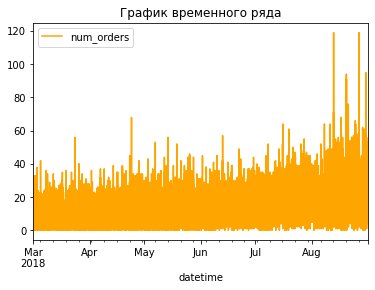

In [7]:
data.plot(title = 'График временного ряда', color = 'orange')

По данному графику невозможно ничего оценить и провести анализ, необходимы дополнительные инструменты обработки временного ряда. Начну с ресемплирования временного ряда.Ресемплирование, или ресемплинг — это изменение интервала со значениями ряда. В каждой группе ресемплинга вычисляется агрегированное значение ряда.

In [8]:
data = data.resample('1H').sum()

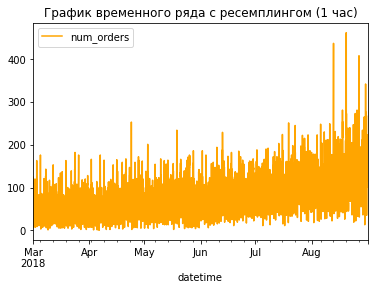

In [9]:
data.plot(title = 'График временного ряда с ресемплингом (1 час)', color = 'orange')

График информативнее не стал, так как интервал ресемплирования очень мал (1 час).

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корректно, первичный осмотр проведен. Ресемплинг был сделан верно.
</div>

Чтобы во временном ряду снизить колебания, применю скользящее среднее.
Скользящее среднее — метод сглаживания временных рядов. Его суть заключается в поиске значений, которые меньше всего подвержены колебаниям, то есть средних арифметических.

Text(0.5, 1.0, 'Скользящее среднее')

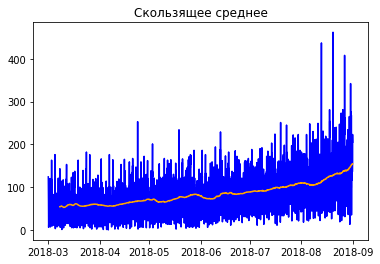

In [10]:
data_rolling = data.rolling(168).mean()
plt.plot(data, color = 'blue')
plt.plot(data_rolling, color='orange')
plt.title('Скользящее среднее')

По графику скользящего среднего видно, что количество заказов растет с течением времени.

In [11]:
data = data.dropna()

Перейду к трендам и сезонностям количества заказов временного ряда. Тренд  — плавное изменение среднего значения ряда без повторяющихся закономерностей. 
Сезонность — циклично повторяющиеся закономерности во временном ряду. Тренды и сезонность зависят от масштаба данных. Нельзя увидеть закономерности, повторяющиеся каждое лето, если есть данные только за год.

In [12]:
decomposed = seasonal_decompose(data) 

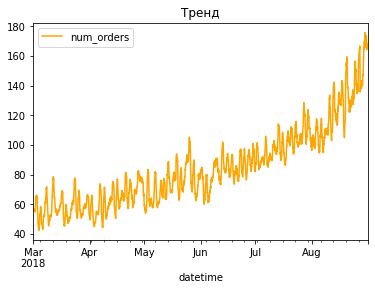

In [13]:
decomposed.trend.plot(title = 'Тренд', color='orange')

График тренда показывает, что растет количество заказов такси с течением времени.

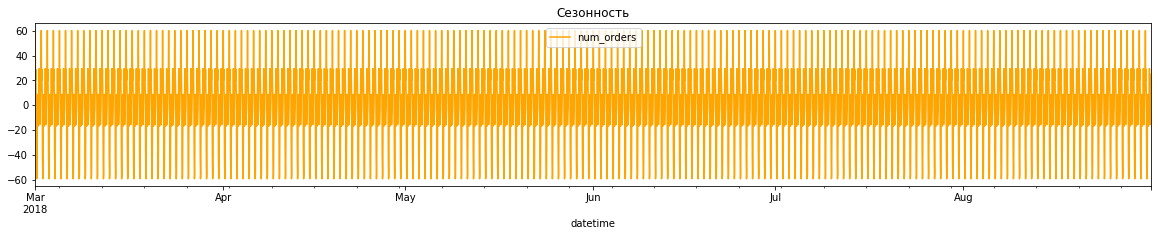

In [14]:
decomposed.seasonal.plot(figsize=(20,3), title = 'Сезонность', color='orange')

График сезонности невозможно проанализировать в таком масштабе, так как сезонность показывается внутри одного дня. А дней в рассматриваемом периоде много. Можно детализировать график (например в периоде 3 дней), чтобы посмотреть как меняется сезонность в течение дня.

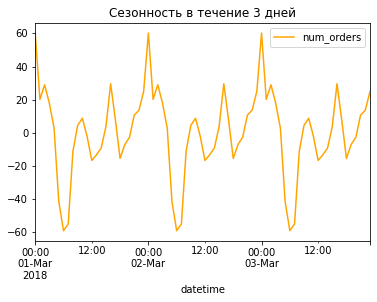

In [15]:
decomposed.seasonal['2018-03-01':'2018-03-03'].plot(title = 'Сезонность в течение 3 дней', color='orange')

График сезонности внутри одного дня показывает, что пик сезонности находится в полночь, меньше всего заказов приходится на раннее утро, потом заказы растут, виден пик в обеденное время и после него заметное снижение.

In [16]:
decomposed = seasonal_decompose(data.resample('1D').sum()) 

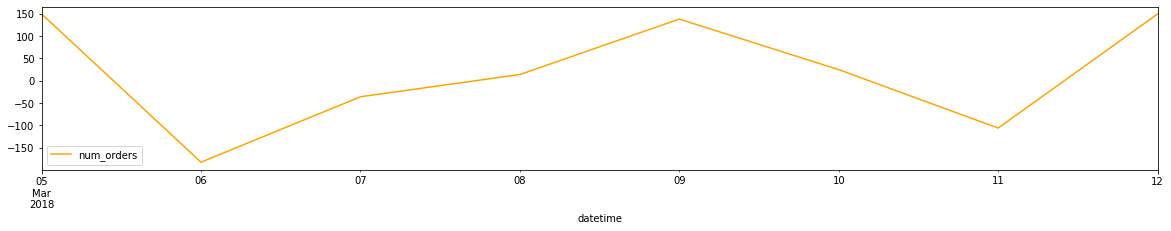

In [17]:
decomposed.seasonal['2018-03-05':'2018-03-12'].plot(figsize=(20,3), color='orange')

При ресемплировании на 1 день, сезонность показывает, что в понедельник большой рост заказов, во вторник минимальное значение, далее в течение недели заказы растут, в пятницу снова пик, в воксресенье резкий спад.

<div class="alert alert-block alert-success">
<b>Успех:</b> Декомпозиция была сделана верно. Хорошо, что сезонность была визуализирована на более коротком интервале!
</div>

## Обучение моделей с подбором гиперпарамтеров

Чтобы обучить модель, необходимо добавить признаков для обучения. Дополнительные признаки - час, день недели, скользящее среднее, лаги. Для того, чтобы не изменять исходны датасет, в функции так же создаю копию данных.

In [18]:
def make_features(df, max_lag, rolling_mean_size):
    data_copy = data.copy()
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [20]:
data1 = make_features(data, 24, 12)

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что эта функция не изменяет глобальную переменную.
</div>

Разбиваю выборки на обучаемую и тестовую (размером 10% от исходных данных). Устанавливаю параметр shuffle=False, чтоюы данные не перемешивались, шли в хронологическом порядке. Выведу минимальные и максимальные значения выборок, чтобы убедиться, что разбитие произошло корректно.

In [21]:
train, test = train_test_split(data1, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Получить признаки для первых значений обучающей выборки нельзя: исторических данных по ним нет. Их нужно удалить.

In [22]:
train = train.dropna()

Целевой признак, который необходимо предсказать - num_orders, формирую датафреймы с признаками и целевым признаком для каждой из выборок.

In [24]:
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Для подбора гиперпараметров буду использовать GridSearchCV. В GridSearchCV нужно использовать TimeSeriesSplit() для параметра cv, так как ряд временной.

<div class="alert alert-block alert-success">
<b>Успех:</b> Разбиение было сделано верно.
</div>

### Обучение моделей на обучаемой выборке

####Линейная регрессия

In [27]:
model_lr = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
cv = TimeSeriesSplit(n_splits=3)
search = GridSearchCV(estimator=model_lr, 
                      param_grid=parameters, 
                      cv=cv, 
                      scoring='neg_root_mean_squared_error', 
                      verbose=False)

result = search.fit(features_train, target_train)
print('Best Score для модели Линейной Регрессии: %s' % result.best_score_)
print('Best Hyperparameters для модели Линейной Регрессии: %s' % result.best_params_)

Best Score для модели Линейной Регрессии: -27.708173431826783
Best Hyperparameters для модели Линейной Регрессии: {'fit_intercept': False, 'normalize': True}


<div class="alert alert-block alert-success">
<b>Успех:</b> Молодец, что использовала подходящий под данные сплиттер!
</div>

#### Случайный лес

In [28]:
model_forest = RandomForestRegressor(random_state=12345)
cv = TimeSeriesSplit(n_splits=3)
parametrs = {'n_estimators': range(50, 81, 10),'max_depth': [6,10,14]}
search = GridSearchCV(estimator=model_forest, 
                      param_grid=parametrs,
                      cv=cv, 
                      verbose=False, 
                      scoring='neg_root_mean_squared_error')
result = search.fit(features_train, target_train)

print('Best Score для модели случайного леса: %s' % result.best_score_)
print('Best Hyperparameters для модели случайного леса: %s' % result.best_params_)

Best Score для модели случайного леса: -26.79841483103843
Best Hyperparameters для модели случайного леса: {'max_depth': 14, 'n_estimators': 70}


#### CatBoost

In [ ]:
model_cat = CatBoostRegressor(loss_function='RMSE')
cv = TimeSeriesSplit(n_splits=3)
parameters = {'learning_rate': [0.1, 0.5],
              'iterations': [500],
              'depth': [5,9]}

search = GridSearchCV(estimator=model_cat, 
                      param_grid=parameters,
                      cv=cv, 
                      scoring='neg_root_mean_squared_error',
                      verbose=False)
result = search.fit(features_train, target_train)

print('Best Score для модели catboost: %s' % result.best_score_)
print('Best Hyperparameters catboost: %s' % result.best_params_)

**Примечание** Почему-то для CatBoost параметр verbose=False не работает и в output выходит полотно с перебором всевозможных значений. Для того, чтобы это не занимало большее пространство проекта, output удалила, получившиеся лучшие параметры вставила ниже.

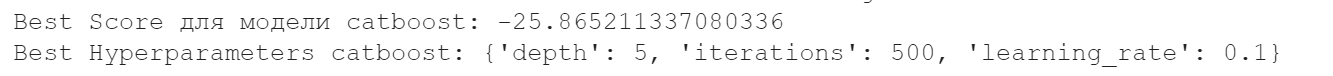

#### Light GBM

In [31]:
model_gbm = LGBMRegressor(random_state=12345)
cv = TimeSeriesSplit(n_splits=3) 
parameters = {'n_estimators': [500, 1000],
              'num_leaves': [50,80], 
              'learning_rate':[0.05, 0.1, 0.5]}

search = GridSearchCV(estimator=model_gbm, 
                      param_grid=parameters,
                      cv=cv, 
                      verbose=False, 
                      scoring='neg_root_mean_squared_error')

result = search.fit(features_train, target_train)

print('Best Score для модели Light GBM: %s' % result.best_score_)
print('Best Hyperparameters Light GBM: %s' % result.best_params_)

Best Score для модели Light GBM: -26.755064007701293
Best Hyperparameters Light GBM: {'learning_rate': 0.05, 'n_estimators': 500, 'num_leaves': 50}


**Вывод** 
Все модели при обучении и предсказании на обучаемой выборке показали приемлемый результат (RMSE менее 48). Лучше всего результат у модели CatBoost, далее у модели Light GBM. Худший результат у модели Linear Regression. Метрика качества могла бы быть еще лучше, если перебирать большее количество гиперпараметров. Я в обучении ограничилась некоторым количеством параметров, чтобы не перегружать среду выполнения, а так же сэкономить время выполнения проекта.

<div class="alert alert-block alert-success">
<b>Успех:</b> Молодец, что попробовала разные модели в этом шаге!
</div>

### Прогноз на тестовой выборке

In [32]:
def time_rmse (model, features_train, target_train, features_test, target_test):
    start = time.time()
    model.fit(features_train, target_train)
    end = time.time()
    time_to_fit = end - start
    
    start = time.time()
    predictions = model.predict(features_test)
    end = time.time()
    time_to_predict = end - start
    
    rmse = mean_squared_error(target_test, predictions)**0.5
    
    return print(f'Метрика качества (RMSE) модели: {rmse}; Время обучения модели: {time_to_fit}; Скорость предсказания: {time_to_predict}')

#### Линейная регрессия

In [33]:
model = LinearRegression(fit_intercept=False, normalize=True)
time_rmse(model, features_train, target_train, features_test, target_test)

Метрика качества (RMSE) модели: 45.19222075742227; Время обучения модели: 0.018178939819335938; Скорость предсказания: 0.00787663459777832


#### Случайный лес

In [34]:
model = RandomForestRegressor(max_depth=14, n_estimators=70)
time_rmse(model, features_train, target_train, features_test, target_test)

Метрика качества (RMSE) модели: 43.50794579199192; Время обучения модели: 5.266676187515259; Скорость предсказания: 0.027139902114868164


#### CatBoost

In [35]:
model = CatBoostRegressor(loss_function="RMSE",
                          depth=5, 
                          iterations=500, 
                          learning_rate=0.1)
time_rmse(model, features_train, target_train, features_test, target_test)

0:	learn: 36.9507113	total: 14.3ms	remaining: 7.13s
1:	learn: 35.3964026	total: 27.2ms	remaining: 6.78s
2:	learn: 33.9825388	total: 39.3ms	remaining: 6.51s
3:	learn: 32.7843730	total: 57.5ms	remaining: 7.13s
4:	learn: 31.7881169	total: 73.8ms	remaining: 7.3s
5:	learn: 30.8050151	total: 84.1ms	remaining: 6.92s
6:	learn: 30.0024498	total: 105ms	remaining: 7.37s
7:	learn: 29.3208336	total: 118ms	remaining: 7.24s
8:	learn: 28.6395772	total: 137ms	remaining: 7.47s
9:	learn: 28.0765696	total: 157ms	remaining: 7.7s
10:	learn: 27.5849661	total: 168ms	remaining: 7.48s
11:	learn: 27.0898166	total: 180ms	remaining: 7.33s
12:	learn: 26.6738986	total: 197ms	remaining: 7.37s
13:	learn: 26.2863401	total: 210ms	remaining: 7.3s
14:	learn: 25.9838123	total: 231ms	remaining: 7.46s
15:	learn: 25.7068820	total: 246ms	remaining: 7.46s
16:	learn: 25.4852533	total: 262ms	remaining: 7.45s
17:	learn: 25.2339144	total: 279ms	remaining: 7.48s
18:	learn: 25.0112711	total: 294ms	remaining: 7.46s
19:	learn: 24.84879

In [36]:
model = LGBMRegressor(learning_rate=0.05, n_estimators=500, num_leaves=50)
time_rmse(model, features_train, target_train, features_test, target_test)

Метрика качества (RMSE) модели: 42.384091635239336; Время обучения модели: 12.658803701400757; Скорость предсказания: 0.0175168514251709


<div class="alert alert-block alert-success">
<b>Успех:</b> Тестирование было сделано верно.
</div>

### Сравнение результатов

In [37]:
result = pd.DataFrame({'model':['LinearRegression','RandomForestRegressor','CatBoostRegressor','LGBMRegressor'],
             'RMSE':[45.19,43.51,41.07,42.38],
             'fittime':[0.018,5.267,4.767,12.658],
             'predicttime':[0.008,0.027,0.004,0.017]})
result

,model,RMSE,fittime,predicttime
0,LinearRegression,45.19,0.018,0.008
1,RandomForestRegressor,43.51,5.267,0.027
2,CatBoostRegressor,41.07,4.767,0.004
3,LGBMRegressor,42.38,12.658,0.017


## Вывод

Каждая из моделей прошла допустимый порог значения метрики качества RMSE, все получившиеся значения менее 48. Лучший результат показала модель CatBoostRegressor, метрика RMSE чуть больше 41. К тому же у этой модели скорость предсказания лучше всего. Мой выбор - модель CatBoostRegressor.

Интересно заметить, что метрика качества на тестовой выборке значительно ухудщилась по сравнению с метрикой на обучаемой выборке. Это может означать, что модель недообучилась или переобучилась.

Построю график, чтобы посмотреть визуально, насколько совпадают предсказания выбранной модели CatBoostRegressor с исходынми значениями тестовой выборки.

In [ ]:
model = CatBoostRegressor(loss_function="RMSE",
                          depth=5, 
                          iterations=500, 
                          learning_rate=0.1)
model.fit(features_train, target_train)
predictions = model.predict(features_test)

plt.figure(figsize=(13,6))
plt.title('Исходные и предсказанные значения модели CatBoostRegressor')
plt.plot(target_test, label='Initial data', color='yellow')
predictions = pd.Series(predictions, index=target_test.index)
plt.plot(predictions, label ='Predicted data', color='orange')

<div class="alert alert-block alert-success">
<b>Успех:</b> Приятно видеть вывод в конце проекта! Хорошо, что предсказания были визуализированы!
</div>